# Transformer Fraud Classifier

#### Introduction
Until around 2019 Recurrent Neural Nets (RNN's) and LSTM's more specifically dominated the NLP domain. Most of the NLP tasks like, machine translation, used LSTM's.

Since 2019 the LSTM's have been largely replaced by Transformer based architectures in the NLP domain. Transformers were intially described in; [Attention is all you need](https://arxiv.org/abs/1706.03762). Transformer based models like BERT and GTP have re-shaped the NLP domains.

They look pretty impressive and complex, but are mainly concepts that were already covered in the example notebooks. If we look at an archictecture diagram, we can see that it is built for sequence to sequence sort of problems. (Seq2Seq models are for instance Machine Translation where we get a sequence of words in one sequence and need to translate return the translation as a sequence of words). 

If we build a simple classifier we can focus on the __left block__ of the picture. (I.e. the encoder part). Our classifier architecture will *not* contain the right part with the outputs embedding as 'input'.


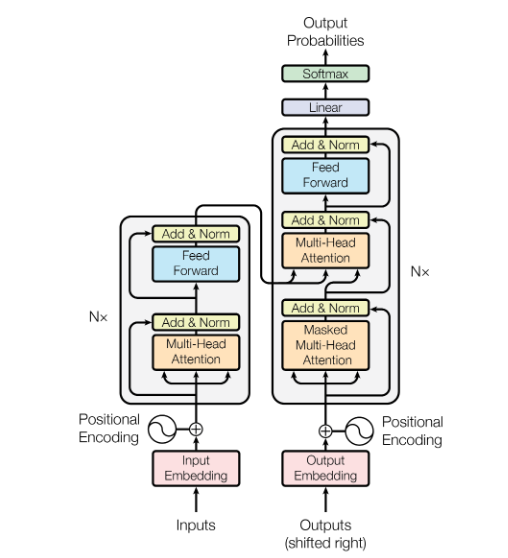
Picture from __Attention is all you need__ by Ashish Vaswani et all [Attention is all you need](https://arxiv.org/abs/1706.03762) Source; *arXiv:1706.03762*

- We can see that we start with an input and run it through an embedding. 
- Then we do a process named positional encoding. (More on this later)
- After than we apply attention. The idea of attention is similar to the one explained in an earlier notebook, though that was a simpler implementation that this one. Standard attention here basically reconstruct the entire sequence as a weighted sum over all the series.
- Which is then followed by a set of FeedForward layers. 

#### Positional Encoding
Because transformers use a feedforward main body, we are back to square one where we assume the information about the order of payments gets lost. Transformers solve this by adding in positional information. The original paper uses __Positional Encoding__ a rather complex scheme with sine and cosine waves of different frequencies.

As we know the length of our transaction series and it is fixed we will implement a simpler __Positional Embedding__. A positional Embedding will encode the position, we give it the transaction-number as input and the output will be the coordinates of that number. That means the model can learn about the positions. It can position the numbers in the embedding space in a manner that reduces the loss. 

In the original implementation the encoding is element-wise added to the original vector. Initial tests with this data showed that this completely distroyed the performance, so we decided to concatenate them on the second dimension. The input to the embedding are numbers 1 to `series_length`. The output will be matrix of size (series_length, dimension_size).


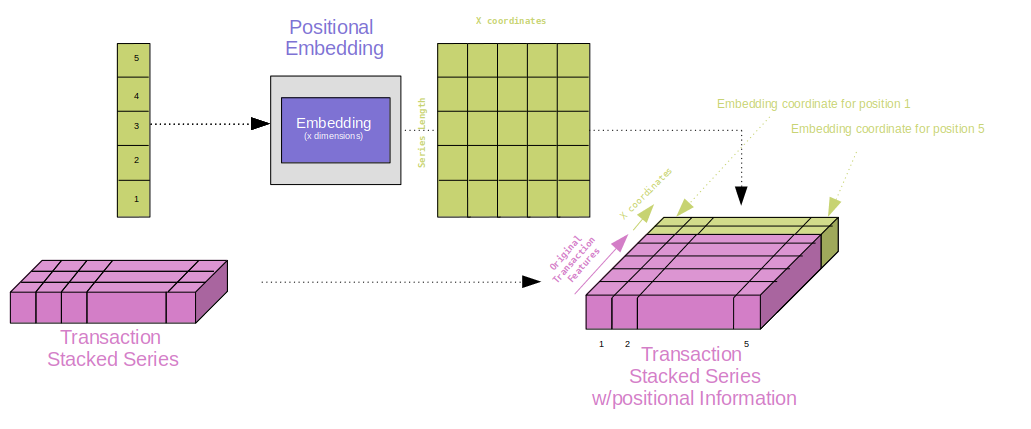

---
#### Note on the data set 
The data set used here is not particularly complex and/or big. It's not really all that challenging to find the fraud. In an ideal world we'd be using more complex data sets to show the real power of Deep Learning. There are a bunch of PCA'ed data sets available, but the PCA obfuscates some of the elements that are useful. 
*These examples are meant to show the possibilities, it's not so useful to interpret their performance on this data set*

## Imports

In [1]:
import torch
import numpy as np
import pandas as pd
import datetime as dt
import gc

import d373c7.features as ft
import d373c7.engines as en
import d373c7.pytorch as pt
import d373c7.pytorch.models as pm
import d373c7.plot as pl

## Set a random seed for Numpy and Torch
> Will make sure we always sample in the same way. Makes it easier to compare results. At some point it should been removed to test the model stability.

In [2]:
# Numpy
np.random.seed(42)
# Torch
torch.manual_seed(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

## Define base feature and read the File
The base features are features found in the input file. They need to be defined after which the file can be read using the `EnginePandasNumpy`. Using the `from_csv` method.

In [3]:
# Change this to read from another location
file = '../../../../data/bs140513_032310.csv'

In [4]:
step = ft.FeatureSource('step', ft.FEATURE_TYPE_INT_16) 
customer = ft.FeatureSource('customer', ft.FEATURE_TYPE_STRING)
age = ft.FeatureSource('age', ft.FEATURE_TYPE_CATEGORICAL)
gender = ft.FeatureSource('gender', ft.FEATURE_TYPE_CATEGORICAL)
merchant = ft.FeatureSource('merchant', ft.FEATURE_TYPE_CATEGORICAL)
category = ft.FeatureSource('category', ft.FEATURE_TYPE_CATEGORICAL)
amount = ft.FeatureSource('amount', ft.FEATURE_TYPE_FLOAT)
fraud = ft.FeatureSource('fraud', ft.FEATURE_TYPE_INT_8)

base_features = ft.TensorDefinition(
    'base', 
    [
        step,
        customer,
        age,
        gender,
        merchant,
        category,
        amount,
        fraud
    ])

# Function to calculate the date and time from the step
def step_to_date(step_count: int):
    return dt.datetime(2020, 1, 1) + dt.timedelta(days=int(step_count))

# Function to calculate the time difference between all rows and normalise
def calc_delta(dates):
    if isinstance(dates, pd.DataFrame):
        res = dates.diff() / np.timedelta64(190, 'D')
        res = res.fillna(0).abs()
        return res
    else:
        # There was only 1 row
        return 0

date_time = ft.FeatureExpression('date', ft.FEATURE_TYPE_DATE_TIME, step_to_date, [step])
date_time_delta = ft.FeatureExpressionSeries('delta', ft.FEATURE_TYPE_FLOAT_32, calc_delta, [date_time])

intermediate_features = ft.TensorDefinition(
    'intermediate', 
    [
        customer,
        step,
        age,
        gender,
        merchant,
        category,
        amount,
        fraud
    ])

age_i = ft.FeatureIndex('age_index', ft.FEATURE_TYPE_INT_8, age)
gender_i = ft.FeatureIndex('gender_index', ft.FEATURE_TYPE_INT_8, gender)
merchant_i = ft.FeatureIndex('merchant_index', ft.FEATURE_TYPE_INT_16, merchant)
category_i = ft.FeatureIndex('category_index', ft.FEATURE_TYPE_INT_16, category)
amount_scale = ft.FeatureNormalizeScale('amount_scale', ft.FEATURE_TYPE_FLOAT_32, amount)
fraud_label = ft.FeatureLabelBinary('fraud_label', fraud)

cust_learn_features = ft.TensorDefinition(
    'customer_learning', 
    [
        age_i,
        gender_i,
    ])

trx_learn_features = ft.TensorDefinition(
    'transaction_learning', 
    [
        customer,
        date_time,
        merchant_i,
        category_i,
        amount_scale,
        date_time_delta,
        fraud_label
    ])

multi_head_td = ft.TensorDefinitionMulti([cust_learn_features, trx_learn_features])

with en.EnginePandasNumpy(num_threads=8) as e:
    df = e.from_csv(base_features, file, inference=False)
    df = e.from_df(intermediate_features, df, inference=False)
    cust_df = e.from_df(cust_learn_features, df, inference=False)
    trx_df  = e.from_df(trx_learn_features, df, inference=False)
    cust_list = e.to_numpy_list(cust_learn_features, cust_df)
    series_list = e.to_series_stacked(trx_df, trx_learn_features, key_field=customer, time_field=date_time, length=5)

print('Customer data Shapes')
print(cust_list.shapes)
print(cust_list.dtype_names)
print('Series Shapes')
print(series_list.shapes)
print(series_list.dtype_names)

data_list = en.NumpyList(cust_list.lists + series_list.lists)
print('Numpy Shapes')
print(data_list.shapes)    

2021-01-27 16:16:32.675 d373c7.engines.common          INFO     Start Engine...
2021-01-27 16:16:32.675 d373c7.engines.panda_numpy     INFO     Pandas Version : 1.1.4
2021-01-27 16:16:32.675 d373c7.engines.panda_numpy     INFO     Numpy Version : 1.19.2
2021-01-27 16:16:32.676 d373c7.engines.panda_numpy     INFO     Building Panda for : base from file ../../../../data/bs140513_032310.csv
2021-01-27 16:16:32.882 d373c7.engines.panda_numpy     INFO     Building Panda for : <base> from DataFrame. Inference mode <False>
2021-01-27 16:16:32.895 d373c7.engines.panda_numpy     INFO     Done creating base. Shape=(594643, 8)
2021-01-27 16:16:32.896 d373c7.engines.panda_numpy     INFO     Building Panda for : <intermediate> from DataFrame. Inference mode <False>
2021-01-27 16:16:32.906 d373c7.engines.panda_numpy     INFO     Done creating intermediate. Shape=(594643, 8)
2021-01-27 16:16:32.907 d373c7.engines.panda_numpy     INFO     Building Panda for : <customer_learning> from DataFrame. Infere

Customer data Shapes
[(594643, 2)]
['int8']
Series Shapes
[(594643, 5, 2), (594643, 5, 2), (594643, 1)]
['float32', 'int16', 'int8']
Numpy Shapes
[(594643, 2), (594643, 5, 2), (594643, 5, 2), (594643, 1)]


## Wrangle the data
Time to split the data. For time series data it is very important to keep the order of the data. Below split will start from the end and work it's way to the front of the data. Doing so the training, validation and test data are nicely colocated in time. You almost *never* want to plain shuffle time based data.

> 1. Split out a test-set of size `test_records`. This is used for model testing.
> 2. Split out a validation-set of size `validation_records`. It will be used to monitor overfitting during training
> 3. All the rest is considered training data.

For time-series we'll perform an additional action.
> 1. The series at the beginning of the data set will all be more or less empty as there is no history, that is not so useful during training, ideally we have records with history and complete series, sometimes named 'mature' series. We'll throw away the first couple of entries.

__Important__; please make sure the data is ordered in ascending fashion on a date(time) field. The split function does not order the data, it assumes the data is in the correct order.

In [5]:
test_records = 100000
val_records  = 30000 
maturation   = 30000

train_data, val_data, test_data = data_list.split_time(val_records, test_records) 
train_data = train_data[maturation:]

print(f'Training Data shapes {train_data.shapes}')
print(f'Validation Data shapes {val_data.shapes}')
print(f'Test Data shapes {test_data.shapes}')
del data_list
gc.collect()
print('Done')

Training Data shapes [(434643, 2), (434643, 5, 2), (434643, 5, 2), (434643, 1)]
Validation Data shapes [(30000, 2), (30000, 5, 2), (30000, 5, 2), (30000, 1)]
Test Data shapes [(100000, 2), (100000, 5, 2), (100000, 5, 2), (100000, 1)]
Done


## Set-up Devices

In [6]:
device, cpu = pt.init_devices()

2021-01-27 16:16:40.057 d373c7.pytorch.common          INFO     Torch Version : 1.7.1+cu110
2021-01-27 16:16:40.092 d373c7.pytorch.common          INFO     GPU found. Using GPU <0>
2021-01-27 16:16:40.093 d373c7.pytorch.common          INFO     Cuda Version  : 11.0


## Build the model
Build a model of type `TransformerFraudClassifierMulti`, with 1 attention head, a feedforward_size of 32 and 1 linear layer of size 8 at the end.

In [7]:
# Setup Pytorch Datasets for the training and validation
batch_size = 128
train_ds = pt.NumpyListDataSetMulti(multi_head_td, train_data)
val_ds = pt.NumpyListDataSetMulti(multi_head_td, val_data)
train_sampler = pt.ClassSamplerMulti(multi_head_td, train_data).over_sampler()

# Wrap them in a Pytorch Dataloader
train_dl = train_ds.data_loader(cpu, batch_size, num_workers=2, sampler=train_sampler)
val_dl = val_ds.data_loader(cpu, batch_size, num_workers=2)

# Create a Model
m = pm.TransformerFraudClassifierMulti(
    multi_head_td, attention_heads=1, feedforward_size=32, linear_layers=[8]
)
print(m)

TransformerFraudClassifierMulti(
  Number of parameters : 17302
  (head): TensorDefinitionHeadMulti(
    Embedded TDs=['customer_learning', 'transaction_learning']
    (heads): ModuleList(
      (0): TensorDefinitionHead(
        lcs=['Categorical']
        (embedding): Embedding(
          (embeddings): ModuleList(
            (0): Embedding(9, 4)
            (1): Embedding(5, 4)
          )
          (dropout): Dropout(p=0.2, inplace=False)
        )
      )
      (1): TensorDefinitionHead(
        lcs=['Continuous', 'Categorical']
        (embedding): Embedding(
          (embeddings): ModuleList(
            (0): Embedding(51, 25)
            (1): Embedding(16, 7)
          )
          (dropout): Dropout(p=0.2, inplace=False)
        )
      )
    )
  )
  (body): BodyMulti(
    (layers): ModuleList(
      (0): None
      (1): TransformerBody(
        (pos): PositionalEmbedding(
          series_size=5, positional_size=16
          (pos_embedding): Embedding(5, 16)
        )
       

# Start Training
### First find a decent Learning Rate. 
> Create a trainer and run the find_lr function and plot. This functions iterates over the batches gradually increasing the learning rate from a minimum to a maximum learning rate.

2021-01-27 16:16:48.955 d373c7.pytorch.training        INFO     Saving model under ./temp_model.pt
Finding LR in 200 steps: 100%|██████████| 200/200 [00:01<00:00, 162.59it/s]
2021-01-27 16:16:51.456 d373c7.pytorch.training        INFO     Restoring model from ./temp_model.pt


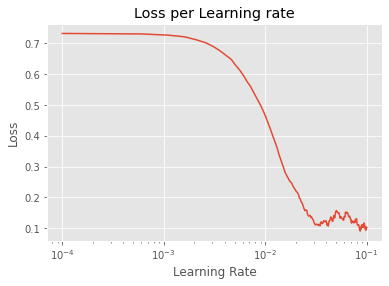

In [8]:
t = pt.Trainer(m, device, train_dl, val_dl)
r = t.find_lr(1e-4, 1e-1, 200)
pl.TrainPlot().plot_lr(r)

## Start Training and plot the results
> We train for __10 epochs__ and __learning rate 5e-3__. That means we run over the total training data set a total of 10 times/epochs where the model learns, after each epoch we use the trained model and perform a test run on the validation set.

Epoch 010/010: 100%|██████████| 3631/3631 [00:18<00:00, 194.93it/s, train_loss=0.0338, train_acc=0.989, val_loss=0.019, val_acc=0.993]


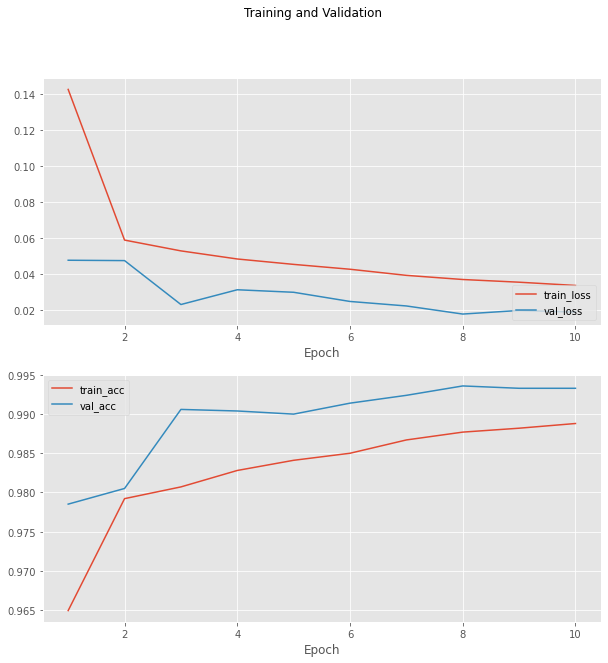

In [9]:
t = pt.Trainer(m, device, train_dl, val_dl)
h = t.train_one_cycle(10, 5e-3)
pl.TrainPlot().plot_history(h, fig_size=(10,10))

## Test the model on the test data

> Test the model on the test set, it is data that was not seen during training and allows us to validate model results.
Our Transformer model did fairly OK, it has one of the highest F1 scores we've seen and does a fairly good job of keeping the False Positve count under control.

Testing in 782 steps: 100%|██████████| 782/782 [00:01<00:00, 616.56it/s]


------------- Classification report -----------------
              precision    recall  f1-score   support

         0.0       1.00      0.99      1.00     98926
         1.0       0.64      0.97      0.77      1074

    accuracy                           0.99    100000
   macro avg       0.82      0.98      0.89    100000
weighted avg       1.00      0.99      0.99    100000


auc score : 0.9994
ap score  : 0.9674
-----------------------------------------------------


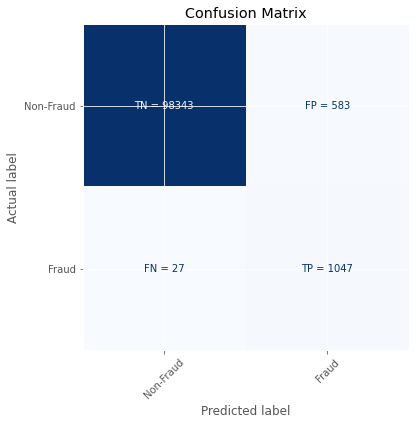

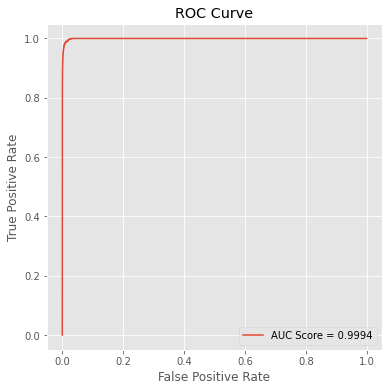

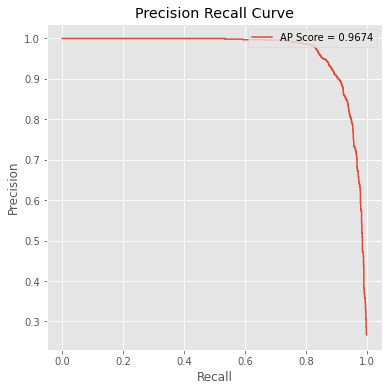

In [10]:
test_ds = pt.NumpyListDataSetMulti(multi_head_td, test_data)
test_dl = test_ds.data_loader(cpu, 128, num_workers=2)

ts = pt.Tester(m, device, test_dl)
pr = ts.test_plot()
tp = pl.TestPlot()
tp.print_classification_report(pr)
tp.plot_confusion_matrix(pr, fig_size=(6,6))
tp.plot_roc_curve(pr, fig_size=(6,6))
tp.plot_precision_recall_curve(pr, fig_size=(6,6))

## Plot Embeddings
> As we have embeddings in this model, we can visualize them.

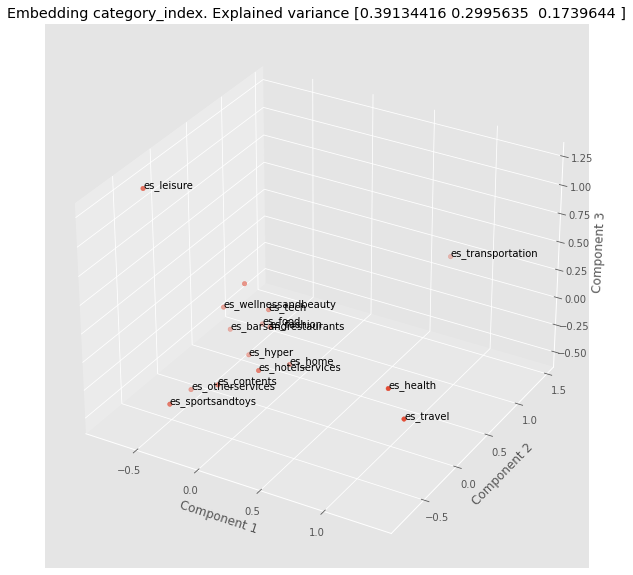

In [11]:
w = m.embedding_weights(category_i, True)
pl.LayerPlot().plot_embedding(category_i, w, dims=3, fig_size=(10,10))

# Conclusion
We saw another type of Neural Net Architecture, the `Transformer`, it did pretty well on this data. But we need to re-iterate this data is not ideal and this model has a lot of parameters, it has more capacity than some of the other models, so the comparison is not fair.